# The Image Classification Dataset
One of the widely used dataset for image classification is the MNIST dataset :cite:`LeCun.Bottou.Bengio.ea.1998`.
It contains binary images of handwritten digits. 

Because it's so simple that it's unsuitable for distinguishing between stronger models and weaker ones.
So we will focus our discussion in the coming sections
on the qualitatively similar, but comparatively complex Fashion-MNIST
dataset :cite:`Xiao.Rasul.Vollgraf.2017`, which was released in 2017.


In [1]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

## Reading the Dataset

We can [**download and read the Fashion-MNIST dataset into memory via the build-in functions in the framework.**]


In [2]:
# `ToTensor` converts the image data from PIL type to 32-bit floating point
# tensors. It divides all numbers by 255 so that all pixel values are between
# 0 and 1
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

100.0%


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100.6%

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100.0%


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



119.3%

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw

Processing...



/data/lczong/.conda/envs/aist4010/lib/python3.8/site-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /tmp/pip-req-build-2tvnr_e8/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


Fashion-MNIST consists of images from 10 categories, each represented
by 6000 images in the training dataset and by 1000 in the test dataset.
A test set is used for evaluating  model performance and not for training.
Consequently the training set and the test set
contain 60000 and 10000 images, respectively.


In [3]:
len(mnist_train), len(mnist_test)

(60000, 10000)

The height and width of each input image are both 28 pixels.

Note that the dataset consists of grayscale images, whose number of channels is 1.

In [4]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

The images in Fashion-MNIST are associated with the following categories:
t-shirt, trousers, pullover, dress, coat, sandal, shirt, sneaker, bag, and ankle boot.

The following function converts between numeric label indices and their names in text.

In [5]:
def get_fashion_mnist_labels(labels):  #@save
    """Return text labels for the Fashion-MNIST dataset."""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

We can now create a function to visualize these examples.


In [12]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy(), cmap="gray")
        else:
            # PIL Image
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

Here are [**the images and their corresponding labels**] (in text)
for the first few examples in the training dataset.


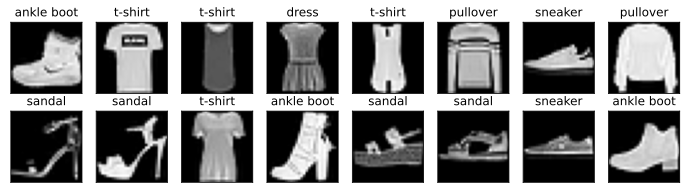

In [13]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=16)))
show_images(X.reshape(16, 28, 28), 2, 8, titles=get_fashion_mnist_labels(y));

## Reading a Minibatch

To make our life easier when reading from the training and test sets,
we use the built-in data iterator rather than creating one from scratch.
Recall that at each iteration, a data iterator
[**reads a minibatch of data with size `batch_size` each time.**]
We also randomly shuffle the examples for the training data iterator.


In [14]:
batch_size = 256

def get_dataloader_workers():  #@save
    """Use 4 processes to read the data."""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())

Let us look at the time it takes to read the training data.


In [15]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'9.51 sec'

## Putting All Things Together

Now we define [**the `load_data_fashion_mnist` function
that obtains and reads the Fashion-MNIST dataset.**]

It returns the data iterators for both the training set and validation set.
In addition, it accepts an optional argument to resize images to another shape.


In [16]:
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

Below we test the image resizing feature of the `load_data_fashion_mnist` function
by specifying the `resize` argument.


In [17]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64
